In [1]:

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
GROQ_API_KEY=os.getenv("GROQ_API_KEY")

In [4]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [8]:
llm.invoke("hi hello how are you?")

AIMessage(content="I'm doing well, thank you! As an AI, I don't have feelings, but I'm ready to assist you. How can I help you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 15, 'total_tokens': 54, 'completion_time': 0.070909091, 'prompt_time': 0.00124834, 'queue_time': 0.247630801, 'total_time': 0.072157431}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd80d6cb-9a59-4642-8430-d84d567b1eb2-0', usage_metadata={'input_tokens': 15, 'output_tokens': 39, 'total_tokens': 54})

In [9]:

url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [12]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [13]:
docs = [WebBaseLoader(url).load() for url in urls]

In [19]:
docs_list = [item for sublist in docs for item in sublist]

In [20]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)

In [21]:
doc_splits=text_splitter.split_documents(docs_list)

In [24]:

vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [25]:

retriever=vectorstore.as_retriever()

In [26]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    
)

In [27]:
tools=[retriever_tool]

In [28]:
retrieve=ToolNode([retriever_tool])

In [29]:
llm_with_tools=llm.bind_tools(tools)

In [34]:
# llm_with_tools.invoke(["waht is Agent System Overview?"])

In [35]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [36]:
'''def handle_query(query):
    print(query[0])
    if "prompt" in query[0] or "agent" in query[0]:
        return llm_with_tools.invoke(query)  # Use tool-bound LLM
    else:
        return llm.invoke(query)  # Use LLM directly without tool'''

'def handle_query(query):\n    print(query[0])\n    if "prompt" in query[0] or "agent" in query[0]:\n        return llm_with_tools.invoke(query)  # Use tool-bound LLM\n    else:\n        return llm.invoke(query)  # Use LLM directly without tool'

In [37]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    print(f"this is my message: {messages}")
    
    if len(messages)>1:
        response=llm.invoke(messages[-1].content)
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [40]:
ai_assistant({"messages":["what is autonomous agent"]})

---CALL AGENT---
this is my message: ['what is autonomous agent']


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ej3m4zmbj', 'function': {'arguments': '{"query":"autonomous agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1036, 'total_tokens': 1121, 'completion_time': 0.154545455, 'prompt_time': 0.022021952, 'queue_time': 0.253464917, 'total_time': 0.176567407}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--61848d9b-5456-4b69-816c-abe7c511ead8-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'autonomous agent'}, 'id': 'ej3m4zmbj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1036, 'output_tokens': 85, 'total_tokens': 1121})]}

In [41]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [42]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

## from langchain hub we can fetch the prompt

In [43]:
prompt = hub.pull("rlm/rag-prompt")

In [44]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [45]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    
    print(f"here is message from generate: {messages}")
    
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [46]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    print(f"here is message from rewrite: {messages}")
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [47]:
workflow=StateGraph(AgentState)
workflow.add_node("My_AI_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Query_Rewriter", rewrite) 
workflow.add_node("Output_Generator", generate)

In [48]:
workflow.add_edge(START,"My_AI_Assistant")

In [49]:
workflow.add_conditional_edges("My_AI_Assistant",
                               tools_condition,
                               {"tools": "Vector_Retriever",
                                END: END,})

In [50]:
workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter"
                            }
                            )
                            

In [51]:
workflow.add_edge("Output_Generator", END)

In [52]:
workflow.add_edge("Query_Rewriter", "My_AI_Assistant")

In [53]:

app=workflow.compile()

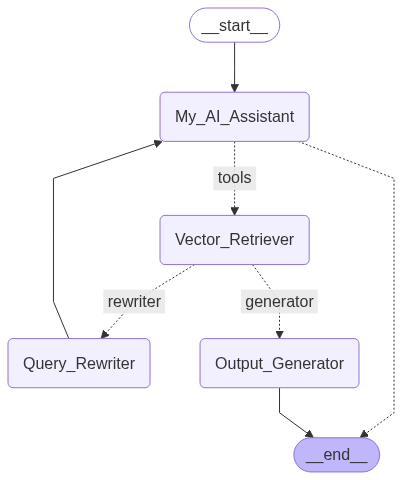

In [54]:

from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
#app.invoke({"messages":["What is a Autonomous Agent?"]})